<h2> AI CA3 <br/><br/>
Naive Bayes Classifiers<br/><br/>
 Kiavash jamshidi 810197486 </h2>

<strong>by reading the comment train file, we calculate the probability of each word and divide them into 6 categories. then by doing the same for books in test file and using bayes rule to find out which category it is.
</strong>


In [1]:
from hazm import *
import csv
import math
import time
import matplotlib.pyplot as plt
from operator import itemgetter

<h2> Q1 </h2> <br/>
stem : در این روش اگر کلمه ای به صورت جمع باشد مفرد آنرا بر میگرداند. به عبارتی دیگر 'ها' و 'ان' و 'ات' آخر آنرا می 
اندازد<br/>
lemmatize : در این روش ریشه کلمه بدست می آید. برای مثال اگر به آن 'تحقیقی' بدهیم 'تحقیق' بر میگرداند <br/>
من از روش دوم استفاده کردم

<h2> Q2 </h2> <br/>
posterior : اگر این مجموعه از لغات را داشته باشیم احتمال آن که موضوع این کتاب ایکس باشد چقدر است<br/>
likelihood : اگر بدانیم موضوع کتاب ایکس است احتمال آنکه این مجموعه از لغات در آن باشند چقدر است <br/>
prior : احتمال آنکه این کتاب  موضوع ایکس را داشته باشد جقدر است ( در این بروژه احتمال همه آنها یکسان است )<br/>
evidence : احتمال این که این لغات اتفاق بیفتند جقدر است ( چون کلمات کتاب یکی است می توانیم آنرا نادیده بگیریم )

<h2> Q3 </h2> <br/>
من شیر آب را باز کردم <br/>
من شیر وحشی را دیدم <br/> <br/>
biagram <br/>
به ما کمک میکند و عبارات 'شیر وحشی' و 'شیر آب' را از هم جدا می کند و کلمه شیر در آن با هم فرق میکنند. در این مثال خاص <br/>
n-gram <br/>
کمکی به ما نمیکند اما در خیلی از عبارات ما به بیشتر از ۲ کلمه نیاز داریم

<h2> Q4 </h2> <br/>
چون که کلمه جامعه که مثال آورده شده است به جمله آن بستگی دارد. ما چون<br/> 
bag of words <br/>
در نظر میگیریم باعث می شود که به جمله کاری نداشته باشیم و فقط به خود کلمه توجه کنیم که باعث همین مشکل می شود

<h2> Q5 </h2> <br/>
اگر به کلمه ای رسیدیم که در دسته وجود نداشته باشد احتمال آنرا یک برروی تعداد کلمات داخل آن دسته قرار میدهیم و به بقیه کلماتی که در آن دسته وجود دارند بعد از <br/> train <br/>
به همه آنها یک واحد اضافه میکنیم

In [2]:
AdditiveSmoothing = True

In [3]:
tagger = POSTagger(model='resources/postagger.model')
basedForm = Lemmatizer()
stopWordsDict = {stop : None for stop in stopwords_list()}
categoryNumOfWords, categoryWords = {}, {}
allDetectedClasses = {}
totalClasses = {}
correctClasses = {}
FOne = {}

def thisWordIsTrash(word):
    return word[0] in stopWordsDict or basedForm.lemmatize(word[0]) in stopWordsDict \
        or word[1] == 'PUNC' or word[1] == 'P' \
        or word[1] == 'ADV' or word[1] == 'CONJ' or word[1] == 'DET' \
        or word[1] == 'Pe' or word[1] == 'PRO' or word[1] == 'POSTP'

def numOfWordsInTwoCol(row):
    words = tagger.tag(word_tokenize(row[0] + ' ' + row[1]))
    return len(words)

def getBaseformOfWord(word):
    baseFormOfWord = basedForm.lemmatize(word[0]).split('#')[0]
    return baseFormOfWord

def makeCategories(csvFileRead):
    for row in csvFileRead:
        n = numOfWordsInTwoCol(row)
        if row[2] in categoryNumOfWords:
            categoryNumOfWords[row[2]] += n
        else:
            categoryNumOfWords[row[2]] = n

        if row[2] not in categoryWords:
            categoryWords[row[2]] = {}
            allDetectedClasses[row[2]] = 0
            totalClasses[row[2]] = 0
            correctClasses[row[2]] = 0

def trainData(csvFileRead):
    for row in csvFileRead:
        words = row[0] + ' ' + row[1]
        words = tagger.tag(word_tokenize(words))
        for word in words:
            if thisWordIsTrash(word): continue
            baseFormOfWord = getBaseformOfWord(word)

            if baseFormOfWord in categoryWords[row[2]]:
                categoryWords[row[2]][baseFormOfWord] += 1
            else:
                categoryWords[row[2]][baseFormOfWord] = 1.5
      
    for cat in categoryWords:
        l = len(categoryWords[cat])
        for word in categoryWords[cat]:
            categoryWords[cat][word] = categoryWords[cat][word] / (categoryNumOfWords[cat] + l)
    

def updateFinalResult(result,maximum,finalCat,cat):
    if result > maximum:
        maximum = result
        finalCat = cat
    return maximum, finalCat

def showAccuracy(accuracy,numOfRow):
    print("Final accuracy is {}%".format(math.ceil((accuracy / numOfRow) * 100)))
    print()
    for cat in correctClasses:
        precision = correctClasses[cat] / allDetectedClasses[cat]
        print("Final precision for {} category is {}%".format(cat,math.ceil((correctClasses[cat] / allDetectedClasses[cat]) * 100)))
        recall = correctClasses[cat] / totalClasses[cat]
        print("Final recall for {} category is {}%".format(cat,math.ceil((correctClasses[cat] / totalClasses[cat]) * 100)))
        print("Final F1 for {} category is {}%".format(cat,math.ceil((2 * recall * precision / (recall + precision)) * 100)))
        print()


def showPlot(i):
    tmp = 0
    for cat in categoryWords:
        if tmp < i: 
            tmp += 1
            continue
        if tmp > i: break
        
        res = dict(sorted(categoryWords[cat].items(), key = itemgetter(1))[::-1][:5])
        plt.title(cat[::-1])
        resKeysLst = list(res.keys())
        for r in range(len(resKeysLst)):
            resKeysLst[r] = resKeysLst[r][::-1]
        plt.bar(resKeysLst,res.values())
        print(cat)
        tmp += 1
        

def testNewData(csvFileRead,numOfRow,accuracy):
    i = 0
    for row in csvFileRead:
        numOfRow += 1
        
        content = tagger.tag(word_tokenize(row[0] + ' ' + row[1]))
        maximum = float('-inf')
        finalCat = ""

        for cat in categoryWords:
            result = 0
            for word in content:
                if thisWordIsTrash(word): continue
                baseFormOfWord = getBaseformOfWord(word)

                if baseFormOfWord in categoryWords[cat]:
                    result += math.log10(categoryWords[cat][baseFormOfWord])
                else:
                    l = len(categoryWords[cat])
                    i += 1
                    if AdditiveSmoothing: result += math.log10(0.5/(categoryNumOfWords[cat] + l + i))
                    else: result += -100000
                    
            maximum, finalCat = updateFinalResult(result,maximum,finalCat,cat)
        if finalCat == row[2]: 
            accuracy += 1
            correctClasses[finalCat] += 1
        allDetectedClasses[finalCat] += 1
        totalClasses[row[2]] += 1
    return accuracy, numOfRow

def readCsv(csvfile):
    csvFileRead = csv.reader(csvfile, delimiter=',')
    next(csvFileRead, None)
    csvFileRead = list(csvFileRead)
    return csvFileRead

if __name__ == '__main__':
    t1 = time.time()
    accuracy, numOfRow = 0, 0

    fileTrainCsv = 'books_dataset/books_train.csv'
    with open(fileTrainCsv, newline='') as csvfile:
        print("Training data...")
        csvFileRead = readCsv(csvfile)
        makeCategories(csvFileRead) 
        trainData(csvFileRead)

    fileTestCsv = 'books_dataset/books_test.csv'
    with open(fileTestCsv, newline='') as csvfile:
        print("Testing data...")
        csvFileRead = readCsv(csvfile)
        accuracy, numOfRow = testNewData(csvFileRead,numOfRow,accuracy)

    showAccuracy(accuracy,numOfRow)
    print("Time is {}sec".format(round(time.time() - t1,2)))



Training data...
Testing data...
Final accuracy is 82%

Final precision for جامعه‌شناسی category is 79%
Final recall for جامعه‌شناسی category is 88%
Final F1 for جامعه‌شناسی category is 84%

Final precision for کلیات اسلام category is 92%
Final recall for کلیات اسلام category is 86%
Final F1 for کلیات اسلام category is 89%

Final precision for داستان کودک و نوجوانان category is 77%
Final recall for داستان کودک و نوجوانان category is 87%
Final F1 for داستان کودک و نوجوانان category is 82%

Final precision for داستان کوتاه category is 70%
Final recall for داستان کوتاه category is 74%
Final F1 for داستان کوتاه category is 72%

Final precision for مدیریت و کسب و کار category is 92%
Final recall for مدیریت و کسب و کار category is 92%
Final F1 for مدیریت و کسب و کار category is 92%

Final precision for رمان category is 85%
Final recall for رمان category is 64%
Final F1 for رمان category is 73%

Time is 58.45sec


جامعه‌شناسی


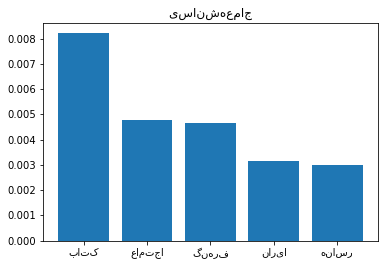

In [4]:
    i = 0
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در جامعه شناسی کلمات کتاب و اجتماع و فرهنگی و ایران و رسانه بیشترین تکرار را داشتند

کلیات اسلام


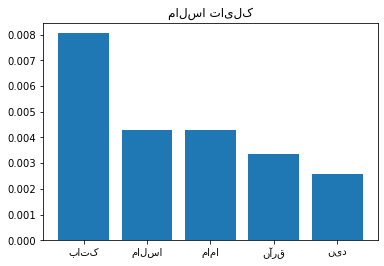

In [5]:
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در کلیات اسلام کلمات کتاب و اسلام و قرآن و دین و حضرت بیشترین تکرار را داشتند

داستان کودک و نوجوانان


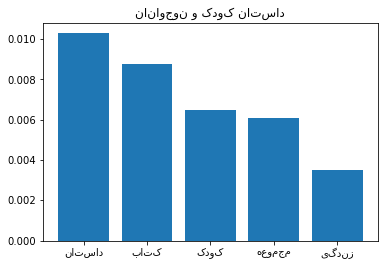

In [6]:
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در داستان کودک و نوجوان کلمات داستان و کتاب و کودک و مجموعه و زندگی بیشترین تکرار را داشتند

داستان کوتاه


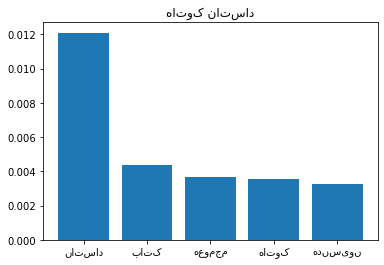

In [7]:
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در داستان کوتاه کلمات داستان و کتاب و مجموعه و کوتاه و نویسنده بیشترین تکرار را داشتند

مدیریت و کسب و کار


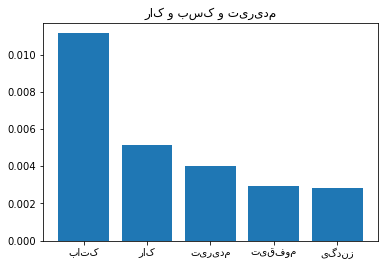

In [8]:
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در مدیری کسب و کار کلمات کتاب و کار و مدیریت و موفقیت و زندگی بیشترین تکرار را داشتند

رمان


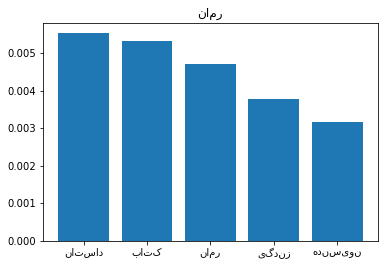

In [9]:
    showPlot(i)
    i += 1

<h2> Q6 </h2> <br/>
در رمان کلمات داستان و کتاب و رمان و زندگی و نویسنده بیشترین تکرار را داشتند

<h2> Q7 </h2> <br/>
چون ممکن است بعضی از آنها <br/> precision <br/> 
صد درصد داشته باشند اما <br/> recall <br/> 
خوبی نداشته باشند و همین طور برعکس برای همین به هر دو معیار نیاز داریم برای همین <br/> F1 <br/> 
را استفاده می کنیم که هر دو معیار را دارد

<h2> Q8 </h2> <br/>
نسبت به میانگین عادی دقیق تر و نزدیکنر به جواب واقعی است

<h2> Q9 </h2> <br/>
در <br/> weighted <br/> 
به هر کدام از <br/> F1 <br/>
ها یک وزن متناسب می دهیم. <br/> 
To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. <br/>
در <br/> macro <br/> 
نیز هم بین همه <br/> F1 <br/> 
ها میانگیم کلی میگیریم

<h2> Q10 </h2> <br/>
در بالای کد اگر میخواهید مقدار بدون <br/>
additive smoothing <br/>
را ببینید آنرا برابر <br/>
false <br/> قرار دهید

<h2> Q11 </h2> <br/>
بدون استفاده از این روش همه این مقادیر درصد کمتری می گیرند چون دقت کمتری دارند

<h2> Q12 </h2> <br/>
در همه موضوعات من مواردی را اشتباه داشتم. احتمالا به چند دلیل است. یک اینکه ما <br/>
bag of words <br/> 
میگیریم در حالی که باید به جمله هم توجه کنیم. ۲ به این دلیل است که کلمات پرتکرار که در تمام موضوعات هستند را حذف نکردم. ۳ آن که ممکن است مقدار دیفالت برای <br/> additive smoothing <br/> 
را بهتر میتوانستم بدهم